In [154]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.int32).flatten()
X_test = np.asarray(X_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.int32).flatten()


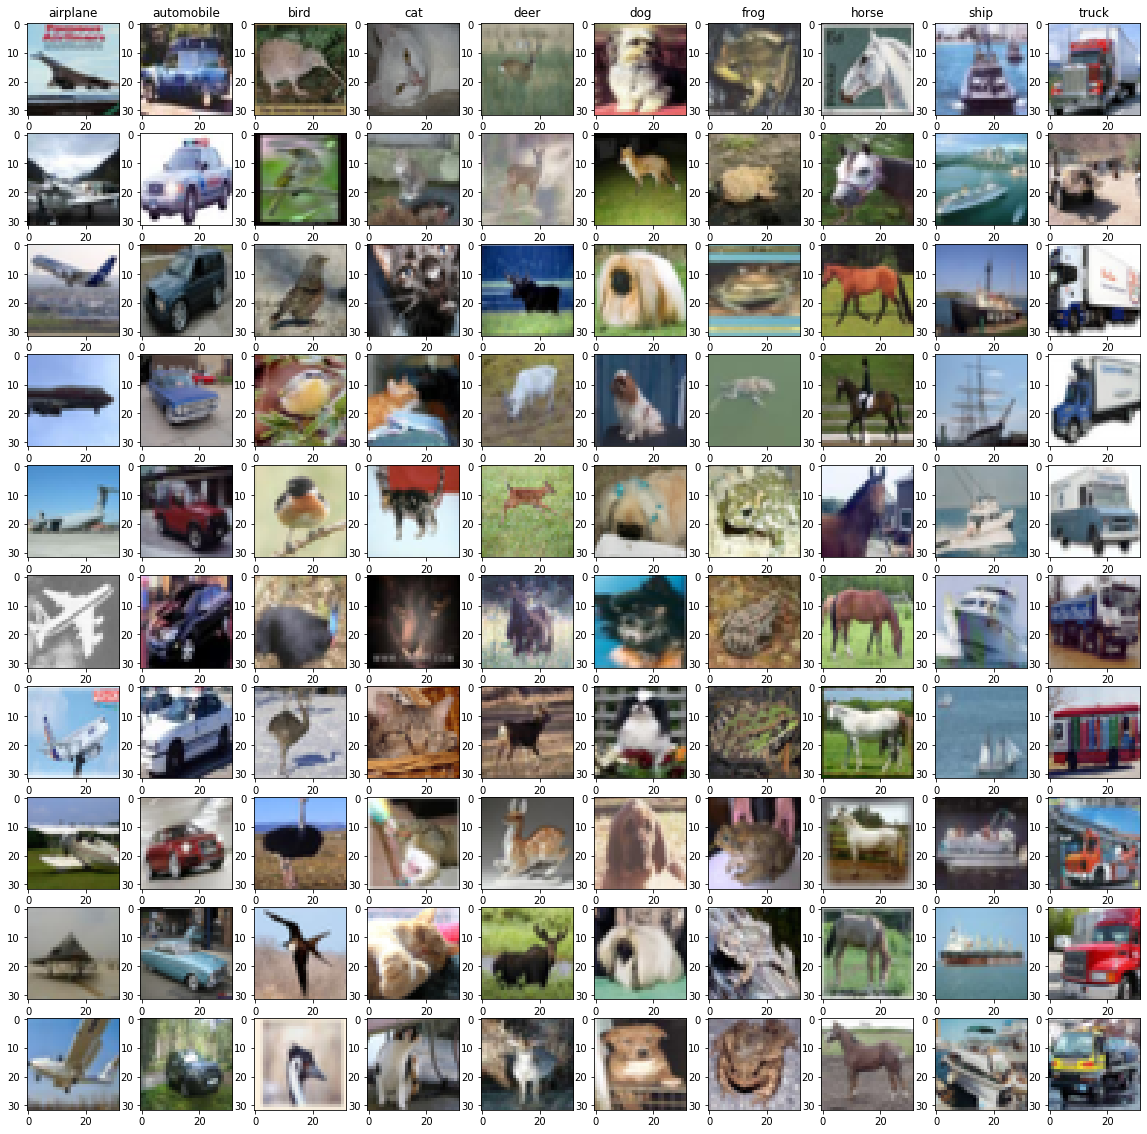

(5000, 32, 32, 3)


C:\Users\mafakheri\AppData\Local\Continuum\anaconda3\envs\tf_20_env\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


'plt.figure(figsize=(20,20))\nfor i in range(25):\n    plt.subplot(5,5, i+1)\n    plt.grid(False)\n    plt.imshow(X_train[i]/255.0, cmap=plt.cm.binary)\n    plt.xlabel(classes[y_train[i]])\n    \nplt.show()'

In [170]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
sample_per_class = 10
num_classes = 10

plt.figure(figsize=(20,20))
for y , cls in enumerate(classes):
    idxs = np.flatnonzero(y_train==y)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i in range(sample_per_class):
        plt.subplot(sample_per_class, num_classes, sample_per_class*i + y + 1)
        plt.imshow(X_train[idxs[i]]/255.0, cmap=plt.cm.binary)
        if i == 0:
            plt.title(cls)
        
plt.show()

"""plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.grid(False)
    plt.imshow(X_train[i]/255.0, cmap=plt.cm.binary)
    plt.xlabel(classes[y_train[i]])
    
plt.show()"""

In [171]:
num_training=49000
num_validation=1000
num_test=10000

BUFFER_SIZE = len(X_train)

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

#print(X_train[0].shape)

mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_val = (X_val - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel

In [172]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

In [173]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [174]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        #tf.keras.Input(shape=input_shape_nobatch)
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation = None, input_shape=(32, 32, 3))
        self.relu1 = tf.keras.layers.ReLU()
        self.mxpool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.drop1 = tf.keras.layers.Dropout(rate = 0.5)
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation = None)
        self.relu2 = tf.keras.layers.ReLU()
        self.mxpool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.drop2 = tf.keras.layers.Dropout(rate = 0.5)
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation = None)
        self.relu3 = tf.keras.layers.ReLU()
        self.mxpool3 = tf.keras.layers.MaxPooling2D((2, 2))
        self.drop3 = tf.keras.layers.Dropout(rate = 0.5)

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(64, activation = 'relu')
        self.fc2 = tf.keras.layers.Dense(64, activation = 'relu')
        self.fc3 = tf.keras.layers.Dense(10)
        
    def call(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu1(x)
        x = self.mxpool1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        #x = self.bn2(x)
        x = self.relu2(x)
        x = self.mxpool2(x)
        x = self.drop2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.mxpool3(x)
        x = self.drop3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)
    


In [185]:
model = MyModel()
inputs = tf.keras.Input(shape=(32,32,3))
model.build(input_shape=(None, 32, 32, 3))
model.call(inputs)
model.summary()

Model: "my_model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
re_lu_51 (ReLU)              (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
re_lu_52 (ReLU)              (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 64)          

In [186]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [187]:
strategy = tf.distribute.MirroredStrategy()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [188]:
BATCH_SIZE_PER_REPLICA = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [189]:
train_dist_ds = strategy.experimental_distribute_dataset(train_ds)
val_dist_ds = strategy.experimental_distribute_dataset(val_ds)

In [190]:
type(train_dist_ds)

tensorflow.python.distribute.input_lib.DistributedDataset

In [62]:
imgbatch, labels = next(iter(train_dist_ds))
(imgbatch[:].shape)

TensorShape([64, 32, 32, 3])

In [191]:
with strategy.scope():
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                               reduction=tf.keras.losses.Reduction.NONE)
    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

    val_loss = tf.keras.metrics.Mean(name='val_loss')
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
    model = MyModel()

In [192]:
with strategy.scope():
    def train_step(inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            predictions = model(images, training = True)
            loss_per_example = loss_object(labels, predictions)
            #tf.print(tf.math.reduce_sum(loss_per_example))
            loss = tf.nn.compute_average_loss(loss_per_example, global_batch_size=GLOBAL_BATCH_SIZE)
            #tf.print(loss)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        #print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(), loss.numpy()))
        train_accuracy(labels, predictions)
        return loss
        
    def val_step (inputs):
        images, labels = inputs
        predictions = model(images, training=False)
        v_loss = loss_object(labels, predictions)

        val_loss(v_loss)
        val_accuracy(labels, predictions)

In [193]:
with strategy.scope():
    @tf.function
    def dist_train_step(inputs):
        per_replica_losses = strategy.run(train_step, args=(inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)
    
    @tf.function
    def dist_val_step(inputs):
        return strategy.run(val_step, args=(inputs,))
    
    EPOCHS = 10
    for epoch in range(EPOCHS):
        total_loss = 0.0
        num_batches = 0
        for x in train_dist_ds:
            total_loss += dist_train_step(x)
            num_batches += 1
        train_loss = total_loss/num_batches
        
        for x in val_dist_ds:
            dist_val_step(x)
            
        if epoch %2 == 0:
            checkpoint.save(checkpoint_prefix)

        template = ("Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, "
                    "Val Accuracy: {}")
        print(template.format(epoch+1, train_loss,
                               train_accuracy.result()*100, val_loss.result(),
                               val_accuracy.result()*100))
        val_loss.reset_states()
        train_accuracy.reset_states()
        val_accuracy.reset_states()

Epoch 1, Loss: 1.7739887237548828, Accuracy: 33.763267517089844, Val Loss: 1.5165400505065918, Val Accuracy: 48.29999923706055
Epoch 2, Loss: 1.4570194482803345, Accuracy: 46.76122283935547, Val Loss: 1.3585487604141235, Val Accuracy: 53.500003814697266
Epoch 3, Loss: 1.3402096033096313, Accuracy: 51.56938934326172, Val Loss: 1.216004729270935, Val Accuracy: 57.79999923706055
Epoch 4, Loss: 1.2703778743743896, Accuracy: 54.163265228271484, Val Loss: 1.1537973880767822, Val Accuracy: 62.0
Epoch 5, Loss: 1.2275806665420532, Accuracy: 55.93061447143555, Val Loss: 1.06703519821167, Val Accuracy: 65.30000305175781
Epoch 6, Loss: 1.1852810382843018, Accuracy: 57.677547454833984, Val Loss: 1.0523943901062012, Val Accuracy: 64.9000015258789
Epoch 7, Loss: 1.1671276092529297, Accuracy: 58.35102081298828, Val Loss: 1.0330314636230469, Val Accuracy: 64.30000305175781
Epoch 8, Loss: 1.13865065574646, Accuracy: 59.553062438964844, Val Loss: 1.0186738967895508, Val Accuracy: 66.19999694824219
Epoch 

In [194]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

In [195]:
path = 'saved_model/'

In [196]:
model.save(path, save_format='tf')

INFO:tensorflow:Assets written to: saved_model/assets


In [198]:
unreplicated_model = tf.keras.models.load_model(path)

unreplicated_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

test_loss, test_acc = unreplicated_model.evaluate(test_ds)

print('Test loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

157/157 [==============================] - 4s 22ms/step - loss: 0.9735 - accuracy: 0.6685
Eval loss: 0.973480224609375, Eval Accuracy: 0.6685000061988831
